In [98]:
import pandas as pd
import pulp
from typing import List, Tuple, Dict


In [99]:

import pandas as pd
import pulp
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict

plt.style.use("ggplot")

df = pd.read_csv('Nuclear waste management.csv', index_col=0)

preorder = {
    1: [5],
    2: [1],
    3: [3, 7],
    4: [11],
    5: [14],
    6: [22, 23],
    7: [24],
    8: [27]
}

preferential_info = [(5,1),
                     (1,3),
                     (3,11),
                     (11,14),
                     (14,22),
                     (22,24),
                     (24,27)]

indifference_information = [(3, 7),
                            (22, 23)]

In [100]:

criteria = df.columns.tolist()
alternatives = {x for t in (preferential_info + indifference_information) for x in t}

pulp.LpSolverDefault.msg = 0
problem = pulp.LpProblem("UTA", pulp.LpMaximize)
print("Kryteria:", criteria)

# zmienne dla wartości funkcji użyteczności wariantów z rankingu
u_vars = {}
for alternative in alternatives:
    for criterion in criteria:
        value = df.loc[alternative, criterion]
        criterion_no = criteria.index(criterion) + 1
    
        u_vars[(criterion, value)] = pulp.LpVariable(
            f"u{criterion_no}({value})", lowBound=0, upBound=1
        )

print(u_vars)



Kryteria: ['C1', 'C2', 'C3', 'C4']
{('C1', 0.6): u1(0.6), ('C2', 0.93): u2(0.93), ('C3', 0.0): u3(0.0), ('C4', 0.73): u4(0.73), ('C1', 1.0): u1(1.0), ('C2', 0.45): u2(0.45), ('C3', 0.57): u3(0.57), ('C4', 0.5): u4(0.5), ('C1', 0.62): u1(0.62), ('C2', 0.4): u2(0.4), ('C3', 0.56): u3(0.56), ('C1', 0.4): u1(0.4), ('C2', 0.9): u2(0.9), ('C4', 0.82): u4(0.82), ('C1', 0.61): u1(0.61), ('C2', 0.54): u2(0.54), ('C3', 0.38): u3(0.38), ('C4', 0.49): u4(0.49), ('C1', 0.69): u1(0.69), ('C2', 0.49): u2(0.49), ('C4', 0.61): u4(0.61), ('C1', 0.32): u1(0.32), ('C2', 0.83): u2(0.83), ('C4', 0.94): u4(0.94), ('C1', 0.59): u1(0.59), ('C2', 0.24): u2(0.24), ('C3', 0.7): u3(0.7), ('C4', 0.63): u4(0.63), ('C1', 0.73): u1(0.73), ('C2', 0.03): u2(0.03), ('C3', 1.0): u3(1.0), ('C1', 0.8): u1(0.8), ('C2', 0.06): u2(0.06), ('C4', 0.67): u4(0.67)}


In [101]:
epsilon = pulp.LpVariable("epsilon", lowBound=0)
problem += epsilon

# preporządek
for a, b in preferential_info:
    problem += (
        pulp.lpSum(u_vars[(c, df.loc[a, c])] for c in criteria)
        >= pulp.lpSum(u_vars[(c, df.loc[b, c])] for c in criteria) + epsilon
    )

for a, b in indifference_information:
    problem += pulp.lpSum(u_vars[(c, df.loc[a, c])] for c in criteria) == pulp.lpSum(
        u_vars[(c, df.loc[b, c])] for c in criteria
    )

In [102]:
worst_values = {criterion: df[criterion].max() for criterion in criteria}
best_values = {criterion: df[criterion].min() for criterion in criteria}

breakpoints = {criterion: sorted(df[criterion].unique()) for criterion in criteria}

u_best = []
u_worst = []


for criterion, value in worst_values.items():
    if (criterion, value) not in u_vars:
        criterion_no = criteria.index(criterion) + 1
        u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)

    u_worst.append(u_vars[(criterion, value)])

for criterion, value in best_values.items():
    if (criterion, value) not in u_vars:
        criterion_no = criteria.index(criterion) + 1
        u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)
        
    u_best.append(u_vars[(criterion, value)])

print( ('C1', 0.34) in u_vars)

for criterion in breakpoints.keys():
    for value in breakpoints[criterion]:
        if (criterion, value) not in u_vars:
            criterion_no = criteria.index(criterion) + 1
            u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)


problem += pulp.lpSum(u_worst) == 0
problem += pulp.lpSum(u_best) == 1

weights = [1/len(criteria) for _ in criteria]

for criterion in criteria:
    problem += u_vars[(criterion, best_values[criterion])] == 1 * weights[criteria.index(criterion)]

# eg. U1(5) <= U1(2) criterion cost
    for i, value in enumerate(breakpoints[criterion]):
        if value == best_values[criterion]:
            continue

        key1 = (criterion, breakpoints[criterion][i])
        key2 = (criterion, breakpoints[criterion][i - 1])

        problem += u_vars[key1] <= u_vars[key2]   
   

False


In [103]:
print(problem)

UTA:
MAXIMIZE
1*epsilon + 0
SUBJECT TO
_C1: - epsilon - u1(0.6) + u1(0.62) + u2(0.4) - u2(0.93) - u3(0.0) + u3(0.56)
 + u4(0.5) - u4(0.73) >= 0

_C2: - epsilon + u1(0.6) - u1(1.0) - u2(0.45) + u2(0.93) + u3(0.0) - u3(0.57)
 - u4(0.5) + u4(0.73) >= 0

_C3: - epsilon - u1(0.61) + u1(1.0) + u2(0.45) - u2(0.54) - u3(0.38)
 + u3(0.57) - u4(0.49) + u4(0.5) >= 0

_C4: - epsilon + u1(0.61) - u1(0.69) - u2(0.49) + u2(0.54) + u3(0.38)
 - u3(0.56) + u4(0.49) - u4(0.61) >= 0

_C5: - epsilon - u1(0.32) + u1(0.69) + u2(0.49) - u2(0.83) - u3(0.0)
 + u3(0.56) + u4(0.61) - u4(0.94) >= 0

_C6: - epsilon + u1(0.32) - u1(0.73) - u2(0.03) + u2(0.83) + u3(0.0) - u3(1.0)
 - u4(0.63) + u4(0.94) >= 0

_C7: - epsilon + u1(0.73) - u1(0.8) + u2(0.03) - u2(0.06) + 0 u3(1.0)
 + u4(0.63) - u4(0.67) >= 0

_C8: - u1(0.4) + u1(1.0) + u2(0.45) - u2(0.9) - u3(0.0) + u3(0.57) + u4(0.5)
 - u4(0.82) = 0

_C9: u1(0.32) - u1(0.59) - u2(0.24) + u2(0.83) + u3(0.0) - u3(0.7) - u4(0.63)
 + u4(0.94) = 0

_C10: u1(1.0) + u2(1.0) + 

In [104]:
problem.solve()
print("Status:", pulp.LpStatus[problem.status])

for v in problem.variables():
    print(v.name, "=", v.varValue)

Status: Optimal
epsilon = 0.035714286
u1(0.32) = 0.25
u1(0.34) = 0.25
u1(0.35) = 0.25
u1(0.4) = 0.25
u1(0.44) = 0.25
u1(0.45) = 0.25
u1(0.48) = 0.25
u1(0.59) = 0.25
u1(0.6) = 0.25
u1(0.61) = 0.071428571
u1(0.62) = 0.071428571
u1(0.64) = 0.0
u1(0.65) = 0.0
u1(0.66) = 0.0
u1(0.68) = 0.0
u1(0.69) = 0.0
u1(0.71) = 0.0
u1(0.73) = 0.0
u1(0.74) = 0.0
u1(0.76) = 0.0
u1(0.78) = 0.0
u1(0.8) = 0.0
u1(0.83) = 0.0
u1(0.87) = 0.0
u1(1.0) = 0.0
u2(0.03) = 0.25
u2(0.06) = 0.10714286
u2(0.22) = 0.10714286
u2(0.24) = 0.10714286
u2(0.25) = 0.10714286
u2(0.27) = 0.10714286
u2(0.3) = 0.10714286
u2(0.4) = 0.10714286
u2(0.44) = 0.10714286
u2(0.45) = 0.10714286
u2(0.49) = 0.10714286
u2(0.54) = 0.0
u2(0.55) = 0.0
u2(0.83) = 0.0
u2(0.86) = 0.0
u2(0.87) = 0.0
u2(0.9) = 0.0
u2(0.91) = 0.0
u2(0.93) = 0.0
u2(0.95) = 0.0
u2(0.97) = 0.0
u2(1.0) = 0.0
u3(0.0) = 0.25
u3(0.38) = 0.25
u3(0.45) = 0.25
u3(0.54) = 0.25
u3(0.56) = 0.25
u3(0.57) = 0.25
u3(0.65) = 0.0
u3(0.7) = 0.0
u3(0.71) = 0.0
u3(0.8) = 0.0
u3(0.81) = 0.0
u

[0.32, 0.34, 0.35, 0.4, 0.44, 0.45, 0.48, 0.59, 0.6, 0.61, 0.62, 0.64, 0.65, 0.66, 0.68, 0.69, 0.71, 0.73, 0.74, 0.76, 0.78, 0.8, 0.83, 0.87, 1.0]
[0.03, 0.06, 0.22, 0.24, 0.25, 0.27, 0.3, 0.4, 0.44, 0.45, 0.49, 0.54, 0.55, 0.83, 0.86, 0.87, 0.9, 0.91, 0.93, 0.95, 0.97, 1.0]
[0.0, 0.38, 0.45, 0.54, 0.56, 0.57, 0.65, 0.7, 0.71, 0.8, 0.81, 0.88, 1.0]
[0.49, 0.5, 0.54, 0.55, 0.6, 0.61, 0.63, 0.65, 0.67, 0.73, 0.75, 0.82, 0.9, 0.91, 0.94, 0.98, 1.0]


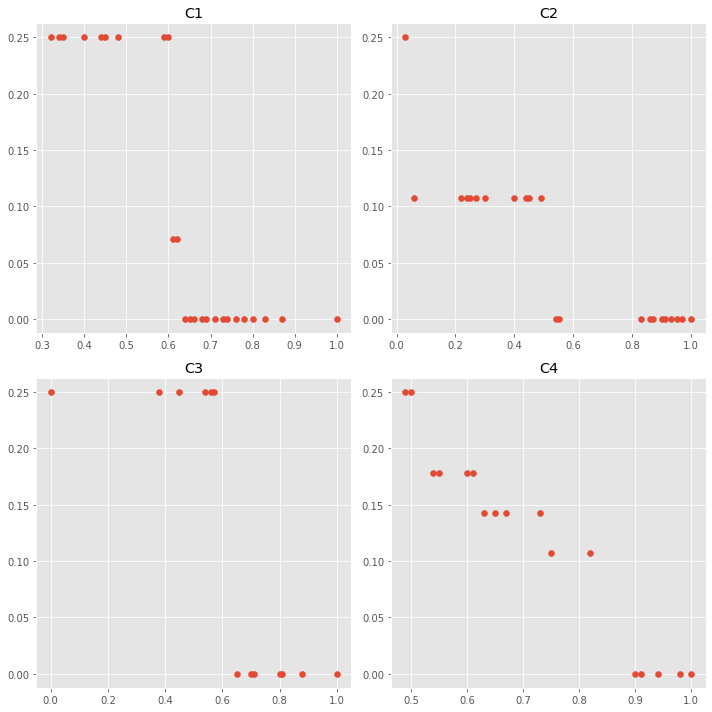

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a figure and a 2x2 grid of subplots

axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over

for i, criterion in enumerate(criteria):
    x = breakpoints[criterion]
    print(x)
    y = [u_vars[(criterion, value)].varValue for value in x]
    axs[i].scatter(x, y)  # Plot on the i-th subplot
    axs[i].set_title(criterion)  # Set the title of the subplot to the criterion

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the figure